## Step 1: Set Local Mode

In [1]:
# Global flags for local testing
g_local_run = True
g_measure_mean_std = False  # Skip for faster testing, use ImageNet defaults

print("✓ Local mode enabled")
print("✓ Using ImageNet normalization stats for speed")

✓ Local mode enabled
✓ Using ImageNet normalization stats for speed


## Step 2: Import Libraries

In [ ]:
%matplotlib inline

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import pytorch_lightning as L
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score, MulticlassPrecision, MulticlassRecall
from torchmetrics import MeanMetric

import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
from PIL import Image

print("✓ Libraries imported successfully")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

✓ Libraries imported successfully
PyTorch version: 2.9.1+cpu
CUDA available: False


## Step 3: Import from src/ (Modular Approach)

In [3]:
# Import configuration classes
from src.config import TrainingConfiguration, DataConfiguration, SystemConfiguration
from src.utils import calculate_dataset_mean_std, get_imagenet_stats

# Import data modules
from src.dataset import KenyanFood13Dataset
from src.datamodule import KenyanFood13DataModule

# Import model and trainer
from src.model import KenyanFood13Classifier
from src.trainer import train_model

print("✓ All modules imported from src/")

✓ All modules imported from src/


## Step 4: Configure for Local Testing

In [4]:
# Create configurations with LOCAL settings optimized for quick testing
train_config = TrainingConfiguration(
    batch_size=8,              # Small batch for testing
    learning_rate=0.001,
    num_epochs=2,              # Just 2 epochs for quick test
    log_interval=5,            # Log frequently
    optimizer="sgd",
    use_scheduler=False,       # Disable scheduler for quick test
    precision="float32",       # Use float32 for compatibility
    pretrained=True           # Skip pre-trained weights for faster testing
)

data_config = DataConfiguration(
    # These paths will auto-detect and use _local.csv variant
    annotations_file="../data/kenyan-food-13/train_local.csv",
    img_dir="../data/kenyan-food-13/images/images",
    input_size=224,
    num_workers=0,             # Use 0 for Windows compatibility
    batch_size=8               # Match training config
)

system_config = SystemConfiguration(
    device="cuda" if torch.cuda.is_available() else "cpu",
    output_dir="./output_local"  # Separate output for local runs
)

print("Configuration Summary:")
print("=" * 50)
print(f"Epochs: {train_config.num_epochs}")
print(f"Batch Size: {train_config.batch_size}")
print(f"Device: {system_config.device}")
print(f"Pre-trained: {train_config.pretrained}")
print(f"Data Path: {data_config.annotations_file}")
print(f"Output: {system_config.output_dir}")
print("=" * 50)

Configuration Summary:
Epochs: 2
Batch Size: 8
Device: cpu
Pre-trained: True
Data Path: ../data/kenyan-food-13/train_local.csv
Output: ./output_local


## Step 5: Create Data Module

**Note:** Using ImageNet stats for faster startup. For production, calculate actual dataset stats.

In [5]:
# Option 1: Use ImageNet defaults (faster)
if not g_measure_mean_std:
    mean, std = get_imagenet_stats()
    print(f"Using ImageNet stats: mean={mean}, std={std}")
    data_module = KenyanFood13DataModule(data_config=data_config, mean=mean, std=std)
else:
    # Option 2: Calculate from local dataset (slower but more accurate)
    print("Calculating dataset statistics...")
    mean, std = calculate_dataset_mean_std(
        annotations_file=data_config.annotations_file,
        img_dir=data_config.img_dir,
        img_size=(data_config.input_size, data_config.input_size),
        sample_size=100,  # Small sample for local testing
        local_mode=g_local_run
    )
    data_module = KenyanFood13DataModule(data_config=data_config, mean=mean, std=std)

# Setup data module
data_module.setup()

print(f"\n✓ Data module ready with {data_module.num_classes} classes")

Using ImageNet stats: mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
Using 80 samples for training.
Dataset initialized with 80 samples belonging to 12 classes.
Using 20 samples for validation.
Dataset initialized with 20 samples belonging to 7 classes.

✓ Data module ready with 12 classes


## Step 6: Inspect Sample Data (Optional)

Batch shape: torch.Size([8, 3, 224, 224])
Labels shape: torch.Size([8])
Sample labels: tensor([11,  9,  4, 11,  2])
Image min/max: -2.118 / 2.640


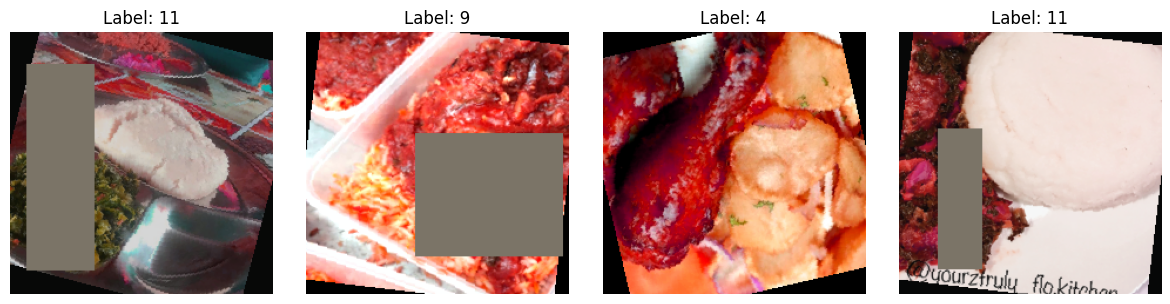

✓ Data looks good!


In [6]:
# Check a batch of training data
train_loader = data_module.train_dataloader()
images, labels = next(iter(train_loader))

print(f"Batch shape: {images.shape}")
print(f"Labels shape: {labels.shape}")
print(f"Sample labels: {labels[:5]}")
print(f"Image min/max: {images.min():.3f} / {images.max():.3f}")

# Visualize a few samples
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
for i in range(4):
    img = images[i].permute(1, 2, 0).numpy()
    # Denormalize for visualization
    img = img * np.array(std) + np.array(mean)
    img = np.clip(img, 0, 1)
    axes[i].imshow(img)
    axes[i].set_title(f"Label: {labels[i].item()}")
    axes[i].axis('off')
plt.tight_layout()
plt.show()

print("✓ Data looks good!")

## Step 7: Create Model

In [7]:
# Create the model
model = KenyanFood13Classifier(train_config, data_module.num_classes)

print(f"✓ Model created: {train_config.model_name}")
print(f"Number of classes: {data_module.num_classes}")

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Loading pre-trained GoogleNet weights...
✓ Pre-trained weights loaded successfully
✓ Model created: googlenet
Number of classes: 12
Total parameters: 5,612,204
Trainable parameters: 5,612,204


## Step 8: Run Quick Training Test

**This will train for just 2 epochs to verify everything works!**

In [8]:
print("\n" + "="*60)
print("Starting LOCAL TRAINING TEST (2 epochs)")
print("="*60 + "\n")

# Train the model
# trained_model, _, checkpoint_callback = training_validation(
#     training_config=train_config,
#     data_config=data_config,
#     system_config=system_config,
#     model=model,
#     data_module=data_module
# )
# Train the model
trained_model, _, checkpoint_callback = train_model(
    training_config=train_config,
    data_config=data_config,
    system_config=system_config,
    model=model,
    data_module=data_module
)

print("\n" + "="*60)
print("LOCAL TRAINING TEST COMPLETE!")
print("="*60)
print(f"Best checkpoint: {checkpoint_callback.best_model_path}")
print(f"Best validation accuracy: {checkpoint_callback.best_model_score:.4f}")
print("\n✓ Ready to run on Kaggle with full dataset!")

Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
GPU available: False, used: False
TPU available: False, using: 0 TPU cores



Starting LOCAL TRAINING TEST (2 epochs)


Starting Training
Using 80 samples for training.
Dataset initialized with 80 samples belonging to 12 classes.
Using 20 samples for validation.
Dataset initialized with 20 samples belonging to 7 classes.
Using 80 samples for training.
Dataset initialized with 80 samples belonging to 12 classes.
Using 20 samples for validation.
Dataset initialized with 20 samples belonging to 7 classes.


c:\rama\learn\prj-2-opencv-dl-pytorch\.venv\Lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:881: Checkpoint directory C:\rama\learn\prj-2-opencv-dl-pytorch\output_local exists and is not empty.

   | Name            | Type                | Params | Mode  | FLOPs
-------------------------------------------------------------------------
0  | model           | GoogLeNet           | 5.6 M  | train | 0    
1  | criterion       | CrossEntropyLoss    | 0      | train | 0    
2  | train_mean_loss | MeanMetric          | 0      | train | 0    
3  | train_accuracy  | MulticlassAccuracy  | 0      | train | 0    
4  | train_f1        | MulticlassF1Score   | 0      | train | 0    
5  | train_precision | MulticlassPrecision | 0      | train | 0    
6  | train_recall    | MulticlassRecall    | 0      | train | 0    
7  | val_mean_loss   | MeanMetric          | 0      | train | 0    
8  | val_accuracy    | MulticlassAccuracy  | 0      | train | 0    
9  | val_f1          | Multiclass

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\rama\learn\prj-2-opencv-dl-pytorch\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.


c:\rama\learn\prj-2-opencv-dl-pytorch\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 10/10 [00:14<00:00,  0.70it/s, v_num=1, valid/loss=2.510, valid/acc=0.0741, valid/precision=0.0202, valid/recall=0.0741, valid/f1=0.0317, step=0.000, train/loss_epoch=2.530, train/acc_epoch=0.0271]

Metric valid/acc improved. New best score: 0.074
Epoch 0, global step 0: 'valid/acc' reached 0.07407 (best 0.07407), saving model to 'C:\\rama\\learn\\prj-2-opencv-dl-pytorch\\output_local\\0-0.0741.ckpt' as top 3
Epoch 0, global step 0: 'valid/acc' reached 0.07407 (best 0.07407), saving model to 'C:\\rama\\learn\\prj-2-opencv-dl-pytorch\\output_local\\0-0.0741.ckpt' as top 3


Epoch 1: 100%|██████████| 10/10 [00:15<00:00,  0.63it/s, v_num=1, valid/loss=2.550, valid/acc=0.000, valid/precision=0.000, valid/recall=0.000, valid/f1=0.000, step=1.000, train/loss_epoch=2.420, train/acc_epoch=0.0848, train/precision=0.0123, train/recall=0.0271, train/f1=0.0162]    

Epoch 1, global step 1: 'valid/acc' reached 0.00000 (best 0.07407), saving model to 'C:\\rama\\learn\\prj-2-opencv-dl-pytorch\\output_local\\1-0.0000-v1.ckpt' as top 3
`Trainer.fit` stopped: `max_epochs=2` reached.
`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 10/10 [00:16<00:00,  0.61it/s, v_num=1, valid/loss=2.550, valid/acc=0.000, valid/precision=0.000, valid/recall=0.000, valid/f1=0.000, step=1.000, train/loss_epoch=2.420, train/acc_epoch=0.0848, train/precision=0.0123, train/recall=0.0271, train/f1=0.0162]

c:\rama\learn\prj-2-opencv-dl-pytorch\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.




Running Final Validation
Using 80 samples for training.
Dataset initialized with 80 samples belonging to 12 classes.
Using 20 samples for validation.
Dataset initialized with 20 samples belonging to 7 classes.
Validation DataLoader 0: 100%|██████████| 3/3 [00:01<00:00,  2.50it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
          step                      2.0
        valid/acc                   0.0
        valid/f1                    0.0
       valid/loss            2.554748773574829
     valid/precision                0.0
      valid/recall                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Training Complete!
Best model saved to: C:\rama\learn\prj-2-op

## Step 9: View TensorBoard Logs (Optional)

In [9]:
# Load and start TensorBoard
%load_ext tensorboard
%tensorboard --logdir output_local/kenyan_food_logs

Reusing TensorBoard on port 6006 (pid 35368), started 3:46:24 ago. (Use '!kill 35368' to kill it.)

## Summary

If you see this, your local test was successful! ✅

**Next Steps:**
1. ✓ Local test passed - code works!
2. Commit changes to Git: `git add . && git commit -m "Ready for Kaggle"`
3. Push to GitHub: `git push origin main`
4. Run on Kaggle using `kaggle_train.ipynb` or clone this repo
5. Train with full dataset and multiple epochs (20-30)
6. Generate predictions and submit to Kaggle competition

**Tips for Kaggle:**
- Increase `num_epochs` to 20-30
- Increase `batch_size` to 64 or 128 (Kaggle has more memory)
- Set `num_workers` to 4
- Enable scheduler: `use_scheduler=True`, `scheduler="cosine"`
- Consider calculating actual dataset mean/std for better results